In [ ]:
#%matplotlib qt

In [1]:
%matplotlib notebook
%matplotlib inline
%autosave 120

Autosaving every 120 seconds


In [2]:
import os
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from pandarallel import pandarallel
import multiprocessing as mp
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from microsim.bp_treatment_strategies import *

from microsim.outcome_model_repository import OutcomeModelRepository
from microsim.outcome_model_type import OutcomeModelType
from microsim.person import Person

from microsim.population import NHANESDirectSamplePopulation

from microsim.bp_treatment_strategies import SprintTreatment

from microsim.sim_settings import simSettings

from microsim.trials.trialset import TrialsetParallel, TrialsetSerial
from microsim.trials.trial_description import TrialDescription
from microsim.trials.logistic_regression_analysis import LogisticRegressionAnalysis
from microsim.trials.linear_regression_analysis import LinearRegressionAnalysis
from microsim.trials.outcome_assessor import OutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AttributeOutcomeAssessor
from microsim.trials.attribute_outcome_assessor import AssessmentMethod
from microsim.trials.risk_filter import RiskFilter
from microsim.trials.trial_utils import get_analysis_name, randomizationSchema

In [4]:
#any microsim dir will work, just need to access the NHANES data
#microsimDir = "/users/PAS2164/deligkaris/MICROSIM/CODE/microsim"
microsimDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/CODE/microsim"
os.chdir(microsimDir)
imputedDataset = pd.read_stata(microsimDir + "/microsim/data/fullyImputedDataset.dta")
dataDir = "/Users/deligkaris.1/OneDrive - The Ohio State University Wexner Medical Center/MICROSIM/NOTEBOOKS/DATA"

In [5]:
quantilesToInclude = pd.read_csv(dataDir + "/dementiaAndCVQuantilesToInclude.csv",index_col=0)
quantiles = pd.read_csv(dataDir + "/dementiaAndCVQuantileThresholds.csv",index_col=0)

In [6]:
#quantilesToInclude

In [7]:
inputDemThresholds=[]
inputCvThresholds=[]
for i,j in quantilesToInclude[["demRisk","cvRisk"]].iterrows():
    inputDemThresholds.append(quantiles.iloc[j["demRisk"]]["dementia"])
    inputCvThresholds.append(quantiles.iloc[j["cvRisk"]]["cv"])

In [8]:
#at the beginning turn on pandarallel if you are planning to use TrialsetSerial
pandarallel.initialize(verbose=1) #microsim by default now does not initialize pandarallel
simSettings.pandarallelFlag = True #with this flag all new population instances will be set to use pandarallel

In [10]:
%%time
# 1.5 hours 150,000 pop and 20 years
# 4 hours 150k pop and 200 years
popSprint = NHANESDirectSamplePopulation(150000, 1999)
popSprint.set_bp_treatment_strategy(SprintTreatment())
aliveSprint, dfSprint = popSprint.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/Clou

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constan

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constan

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


CPU times: user 3h 1min 51s, sys: 13min 46s, total: 3h 15min 37s
Wall time: 3h 56min 3s


/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/population.py:342: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  totalBPMedsAddedCapped.loc[totalBPMedsAddedCapped >= BaseTreatmentStrategy.MAX_BP_MEDS] = BaseTreatmentStrategy.MAX_BP_MEDS


In [12]:
%%time
# 1 hour 10 min 150,000 and 20 years
# 3 hours 15 min 150k pop and 200 years
popUsual = NHANESDirectSamplePopulation(150000, 1999)
#popUsual.set_bp_treatment_strategy(SprintTreatment())
aliveUsual, dfUsual = popUsual.advance_vectorized(200)

/Users/deligkaris.1/Library/Caches/pypoetry/virtualenvs/microsim-54NoInYP-py3.9/lib/python3.9/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age
/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold)

/Users/deligkaris.1/Library/CloudStorage/OneDrive-TheOhioStateUniversityWexnerMedicalCenter/MICROSIM/CODE/microsim/microsim/gfr_equation.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return constant * (x.creatinine / crThreshold) ** exponent * 0.993**x.age


CPU times: user 1h 55min 53s, sys: 17min, total: 2h 12min 53s
Wall time: 3h 15min 27s


This is an approach based on person-years

In [13]:
def getDFForPersonCol(person):
    df = pd.DataFrame(person.get_final_wave_state_as_dict())
    df['dfIndex'] = person.dfIndex
    df['cvRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person, 
                            args=(OutcomeModelType.CARDIOVASCULAR, 1, True), axis='columns')
    df['demRisk'] = df.apply(OutcomeModelRepository().get_risk_for_person,  
                             args=(OutcomeModelType.DEMENTIA, 1, True), axis='columns')
    return df

dfsUsual = popUsual._people.apply(getDFForPersonCol)
dfsSprint = popSprint._people.apply(getDFForPersonCol)

In [14]:
allAgesUsualDF = pd.concat(dfsUsual.tolist())
allAgesSprintDF = pd.concat(dfsSprint.tolist())

In [15]:
allAgesUsualDF["demRisk"].describe()

count    6.044927e+06
mean     2.563327e-02
std      7.938273e-02
min      2.464419e-08
25%      3.283071e-04
50%      2.831796e-03
75%      1.755630e-02
max      8.544072e+00
Name: demRisk, dtype: float64

In [20]:
#allAgesUsualDF.loc[allAgesUsualDF["demRisk"]>1]
allAgesUsualDF.loc[allAgesUsualDF.demRisk > 1, 'demRisk'] = 1
allAgesSprintDF.loc[allAgesSprintDF.demRisk > 1, 'demRisk'] = 1

In [84]:
#allAgesUsualDF.index

In [85]:
allAgesUsualDF.head(10)

,sbp,dbp,a1c,hdl,ldl,trig,totChol,bmi,anyPhysicalActivity,afib,alcoholPerWeek,creatinine,antiHypertensiveCount,statin,waist,alive,gcp,bpMedsAdded,age,baseAge,gender,raceEthnicity,black,current_diabetes,gfr,education,current_bp_treatment,smokingStatus,current_smoker,gcpRandomEffect,miPriorToSim,strokePriorToSim,mi,stroke,ageAtFirstStroke,ageAtFirstMI,ageAtFirstDementia,miInSim,strokeInSim,dementia,baseGcp,gcpSlope,totalYearsInSim,totalBPMedsAdded,totalQalys,dfIndex,cvRisk,demRisk,demRiskQuantile,cvRiskQuantile,cvQuantileNum,demQuantileNum
0,109.623550,58.889917,4.620696,55.535281,125.412361,120.030339,203.937004,29.803268,False,False,2,0.762739,0,False,96.837861,True,58.032829,0.0,48.0,47.0,2,3,False,False,92.652570,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,0.000000,1,0.0,0,45600,0.000843,0.000016,"(1.28e-05, 2.37e-05]","(0.000812, 0.000975]",8,2
1,110.410843,62.327302,4.637168,55.289169,126.570594,122.918718,205.607874,29.730553,False,False,1,0.754969,0,False,96.523707,True,55.039071,0.0,49.0,47.0,2,3,False,False,93.150002,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-5.820282,2,0.0,0,45600,0.000945,0.000039,"(2.37e-05, 4.05e-05]","(0.000812, 0.000975]",8,3
2,110.878390,64.079362,4.656166,55.187391,126.812189,124.728200,206.208388,29.723488,False,False,1,0.747842,0,False,96.509260,True,58.856613,0.0,50.0,47.0,2,3,False,False,93.564797,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-2.993758,3,0.0,0,45600,0.001046,0.000066,"(6.42e-05, 9.55e-05]","(0.000975, 0.00115]",9,5
3,111.195333,65.111199,4.674309,55.143409,126.753355,126.049104,206.433791,29.737838,False,False,1,0.741520,0,False,96.588961,True,54.153535,0.0,51.0,47.0,2,3,False,False,93.868361,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,3.817541,4,0.0,0,45600,0.001152,0.000099,"(9.55e-05, 0.000136]","(0.000975, 0.00115]",9,6
4,111.424697,65.757692,4.691172,55.129698,126.563728,127.085206,206.483560,29.760885,False,False,1,0.735878,0,False,96.707954,True,49.517905,0.0,52.0,47.0,2,3,False,False,94.075985,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-4.703077,5,0.0,0,45600,0.001265,0.000139,"(0.000136, 0.000187]","(0.00115, 0.00135]",10,7
5,111.596923,66.168645,4.706898,55.134864,126.306638,127.933803,206.436243,29.788127,False,False,1,0.730767,0,False,96.846204,True,56.569883,0.0,53.0,47.0,2,3,False,False,94.207904,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-4.635630,6,0.0,0,45600,0.001387,0.000186,"(0.000136, 0.000187]","(0.00135, 0.00156]",11,7
6,111.728906,66.422713,4.721684,55.152933,126.010793,128.648998,206.329116,29.817607,False,False,1,0.726074,0,False,96.994982,True,45.265434,0.0,54.0,47.0,2,3,False,False,94.279981,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,7.051978,7,0.0,0,45600,0.001518,0.000239,"(0.000187, 0.00025]","(0.00135, 0.00156]",11,8
7,111.831010,66.565901,4.735701,55.180382,125.691035,129.264215,206.182337,29.848364,False,False,1,0.721715,0,False,97.149922,True,49.131703,0.0,55.0,47.0,2,3,False,False,94.304023,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-11.304449,8,0.0,0,45600,0.001660,0.000309,"(0.00025, 0.000328]","(0.00156, 0.00179]",12,9
8,111.910058,66.627263,4.749079,55.214959,125.355776,129.801630,206.007850,29.879875,False,False,1,0.717630,0,False,97.308627,True,45.628131,0.0,56.0,47.0,2,3,False,False,94.288857,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,3.866269,9,0.0,0,45600,0.001814,0.000380,"(0.000328, 0.000424]","(0.00179, 0.00204]",13,10
9,111.970782,66.626222,4.761923,55.255136,125.010105,130.276740,205.813213,29.911837,False,False,1,0.713771,0,False,97.469690,True,55.666240,0.0,57.0,47.0,2,3,False,False,94.241196,4,False,2,True,1.560308,0,0,False,False,NaN,NaN,NaN,False,False,False,63.853112,-3.503572,10,0.0,0,45600,0.00

In [ ]:
allAgesUsualDF["mi"]==True

In [21]:
allAgesUsualDF['demRiskQuantile'] = pd.cut(allAgesUsualDF["demRisk"],quantiles["dementia"])
allAgesUsualDF['cvRiskQuantile'] = pd.cut(allAgesUsualDF["cvRisk"],quantiles["cv"])

allAgesSprintDF['demRiskQuantile'] = pd.cut(allAgesSprintDF["demRisk"],quantiles["dementia"])
allAgesSprintDF['cvRiskQuantile'] = pd.cut(allAgesSprintDF["cvRisk"],quantiles["cv"])

In [55]:
allAgesUsualDF = allAgesUsualDF.loc[~allAgesUsualDF['demRiskQuantile'].isna()]
allAgesUsualDF = allAgesUsualDF.loc[~allAgesUsualDF['cvRiskQuantile'].isna()]

allAgesSprintDF = allAgesSprintDF.loc[~allAgesSprintDF['demRiskQuantile'].isna()]
allAgesSprintDF = allAgesSprintDF.loc[~allAgesSprintDF['cvRiskQuantile'].isna()]

In [56]:
allAgesUsualDF['demRiskQuantile'].isna().sum(), allAgesUsualDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [57]:
allAgesSprintDF['demRiskQuantile'].isna().sum(), allAgesSprintDF['cvRiskQuantile'].isna().sum()

(0, 0)

In [58]:
#these are the same for both usual and sprint, the quantile intervals were simply read in this notebook
#they were created in cvDementiaQuantiles
demQuantileNumberForQuantile = {quantile : index for index, quantile in 
                                enumerate(allAgesUsualDF['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantile = {quantile : index for index, quantile in 
                               enumerate(allAgesUsualDF['cvRiskQuantile'].value_counts(sort=False).index)}

allAgesUsualDF['cvQuantileNum'] = allAgesUsualDF['cvRiskQuantile']
allAgesUsualDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesUsualDF['demQuantileNum'] = allAgesUsualDF['demRiskQuantile']
allAgesUsualDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

allAgesSprintDF['cvQuantileNum'] = allAgesSprintDF['cvRiskQuantile']
allAgesSprintDF['cvQuantileNum'].replace(cvQuantileNumberForQuantile, inplace=True)

allAgesSprintDF['demQuantileNum'] = allAgesSprintDF['demRiskQuantile']
allAgesSprintDF['demQuantileNum'].replace(demQuantileNumberForQuantile, inplace=True)

In [109]:
countByDementiaUsual = allAgesUsualDF.loc[allAgesUsualDF["dementia"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFUsual = pd.DataFrame({'demRisk' : countByDementiaUsual.index.get_level_values(0),
                              'cvRisk' : countByDementiaUsual.index.get_level_values(1),
                              'demCount' : countByDementiaUsual.values})

countByDementiaSprint = allAgesSprintDF.loc[allAgesSprintDF["dementia"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFSprint = pd.DataFrame({'demRisk' : countByDementiaSprint.index.get_level_values(0),
                              'cvRisk' : countByDementiaSprint.index.get_level_values(1),
                              'demCount' : countByDementiaSprint.values})

In [110]:
#allAgesUsualDF.loc[allAgesUsualDF["dementia"]==True].groupby(
#                                ['cvQuantileNum', 'demQuantileNum'],sort=True
#                                ).count()

In [111]:
countByMIUsual = allAgesUsualDF.loc[allAgesUsualDF["mi"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()

countByMIDFUsual = pd.DataFrame({'demRisk' : countByMIUsual.index.get_level_values(0),
                              'cvRisk' : countByMIUsual.index.get_level_values(1),
                              'miCount' : countByMIUsual.values})

countByMISprint = allAgesSprintDF.loc[allAgesSprintDF["mi"]==True].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()

countByMIDFSprint = pd.DataFrame({'demRisk' : countByMISprint.index.get_level_values(0),
                              'cvRisk' : countByMISprint.index.get_level_values(1),
                              'miCount' : countByMISprint.values})

In [112]:
countByNoEventUsual = allAgesUsualDF.loc[ (allAgesUsualDF["mi"]==False) &
                                          (allAgesUsualDF["dementia"]==False) &
                                          (allAgesUsualDF["stroke"]==False) 
                                        ].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByNoEventDFUsual = pd.DataFrame({'demRisk' : countByNoEventUsual.index.get_level_values(0),
                              'cvRisk' : countByNoEventUsual.index.get_level_values(1),
                              'noEventCount' : countByNoEventUsual.values})

countByNoEventSprint = allAgesSprintDF.loc[ (allAgesSprintDF["mi"]==False) &
                                            (allAgesSprintDF["dementia"]==False) &
                                            (allAgesSprintDF["stroke"]==False) 
                                          ].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["mi"].count().unstack(fill_value=0).stack()#"mi":irrelevant,just needs to be 1column

countByNoEventDFSprint = pd.DataFrame({'demRisk' : countByNoEventSprint.index.get_level_values(0),
                              'cvRisk' : countByNoEventSprint.index.get_level_values(1),
                              'noEventCount' : countByNoEventSprint.values})

In [63]:
nQuantiles=quantiles.shape[0]-1
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

(40, 40)

In [113]:
numberOfPersonYearsUsual = allAgesUsualDF.shape[0]
numberOfPersonYearsSprint = allAgesSprintDF.shape[0]

In [114]:
#this is done just in case the quantile categories are not ordered properly
countByDementiaArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFUsual["demRisk"].values,
                 countByDementiaDFUsual["cvRisk"].values,
                 countByDementiaDFUsual["demCount"].values):
    countByDementiaArrayUsual[i,j]=k/numberOfPersonYearsUsual

countByDementiaArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFSprint["demRisk"].values,
                 countByDementiaDFSprint["cvRisk"].values,
                 countByDementiaDFSprint["demCount"].values):
    countByDementiaArraySprint[i,j]=k/numberOfPersonYearsSprint

In [115]:
countByMIArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByMIDFUsual["demRisk"].values,
                 countByMIDFUsual["cvRisk"].values,
                 countByMIDFUsual["miCount"].values):
    countByMIArrayUsual[i,j]=k/numberOfPersonYearsUsual

countByMIArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByMIDFSprint["demRisk"].values,
                 countByMIDFSprint["cvRisk"].values,
                 countByMIDFSprint["miCount"].values):
    countByMIArraySprint[i,j]=k/numberOfPersonYearsSprint

In [116]:
countByNoEventArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByNoEventDFUsual["demRisk"].values,
                 countByNoEventDFUsual["cvRisk"].values,
                 countByNoEventDFUsual["noEventCount"].values):
    countByNoEventArrayUsual[i,j]=k/numberOfPersonYearsUsual

countByNoEventArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByNoEventDFSprint["demRisk"].values,
                 countByNoEventDFSprint["cvRisk"].values,
                 countByNoEventDFSprint["noEventCount"].values):
    countByNoEventArraySprint[i,j]=k/numberOfPersonYearsSprint

In [117]:
countByDementiaArrayDiff = abs(countByDementiaArrayUsual-countByDementiaArraySprint)

In [118]:
countByMIArrayDiff = abs(countByMIArrayUsual-countByMIArraySprint)

In [119]:
countByNoEventArrayDiff = abs(countByNoEventArrayUsual-countByNoEventArraySprint)

<IPython.core.display.Javascript object>


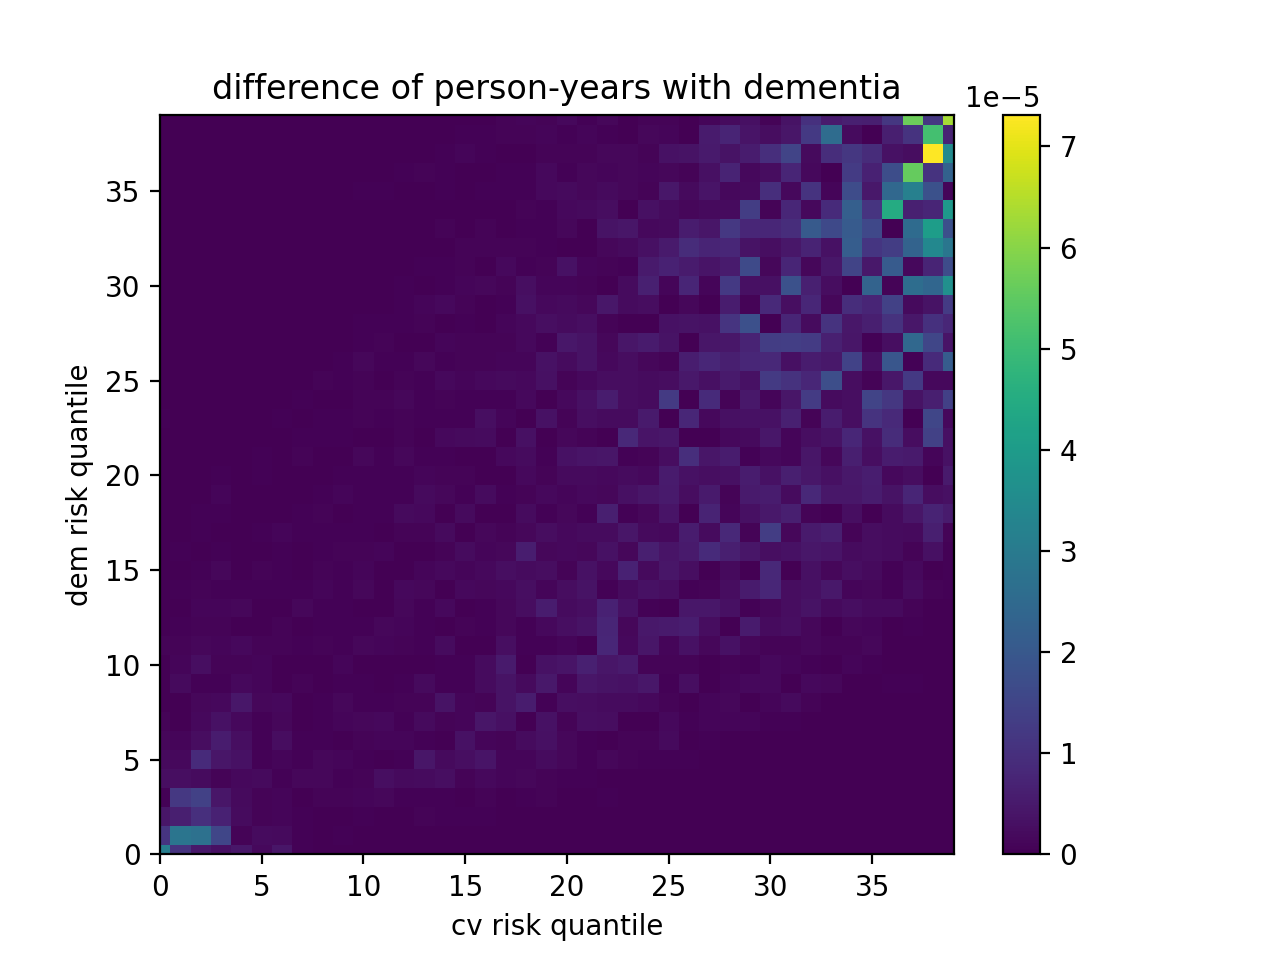

In [120]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByDementiaArrayDiff, shading='nearest')
ax.set_title('difference of person-years with dementia')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [77]:
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
ax = Axes3D(fig)

In [78]:
matplotlib qt

<IPython.core.display.Javascript object>


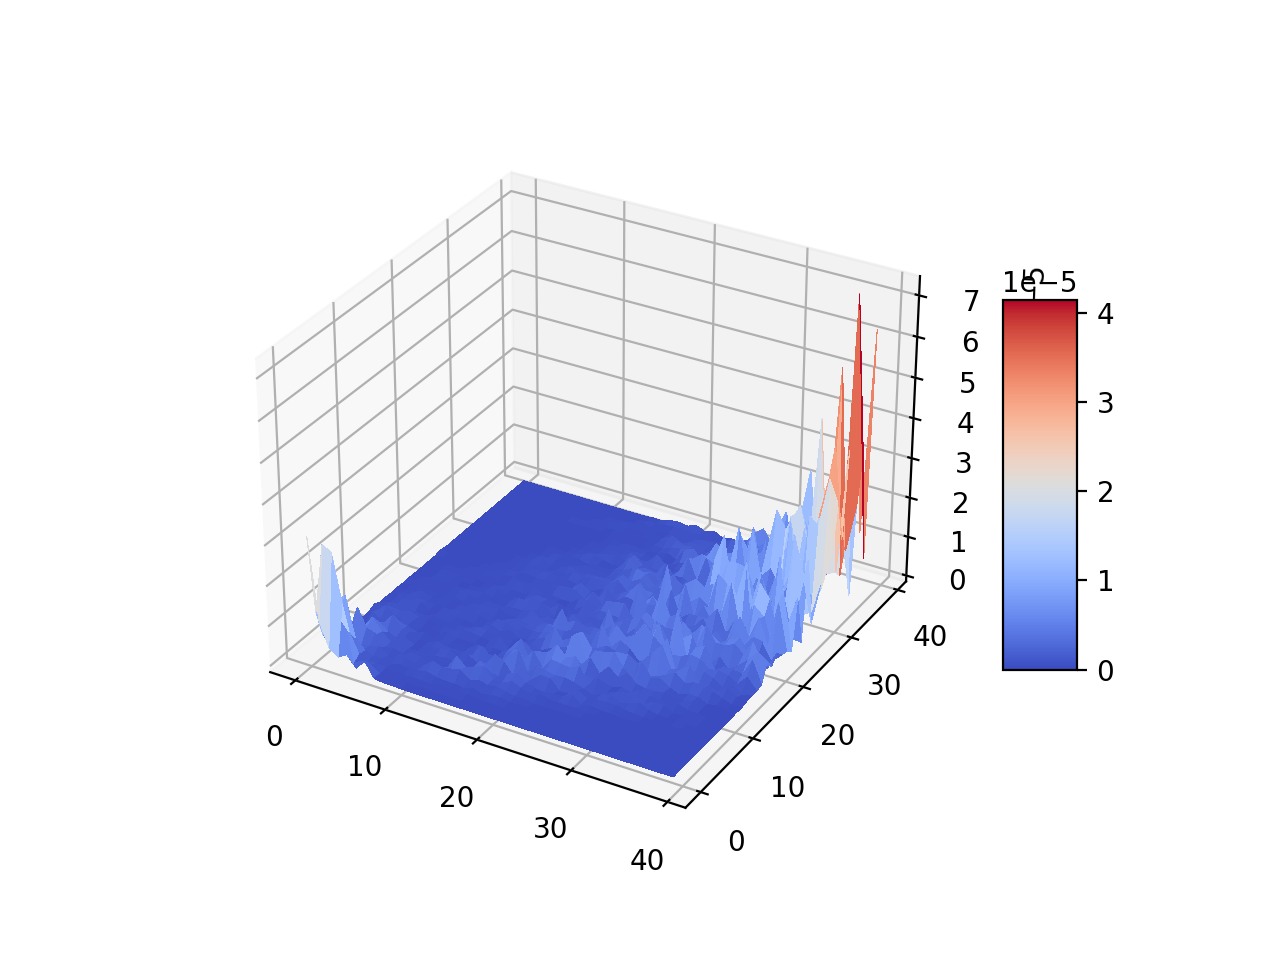

In [121]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByDementiaArrayDiff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


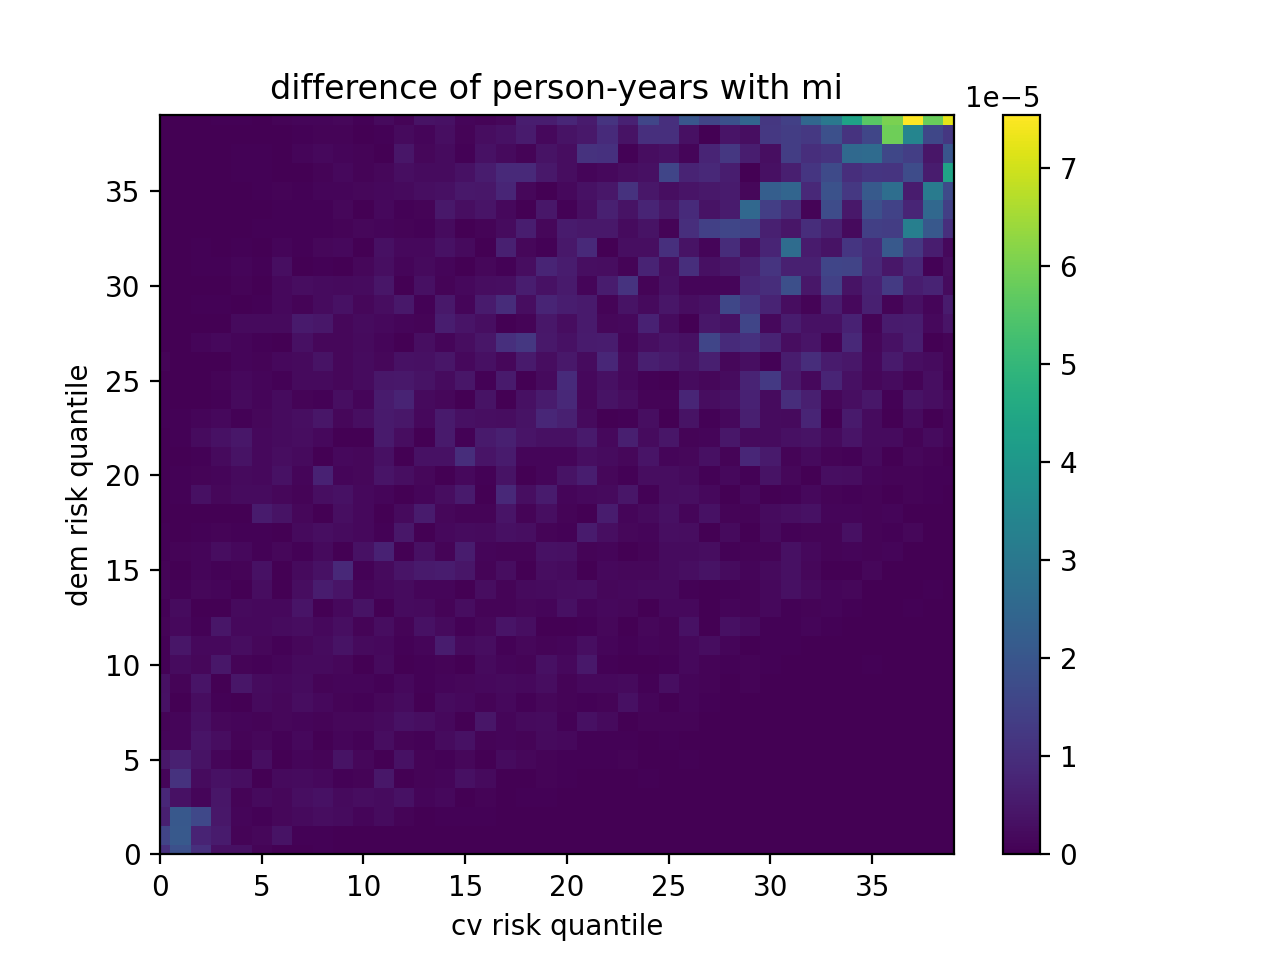

In [122]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByMIArrayDiff, shading='nearest')
ax.set_title('difference of person-years with mi')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


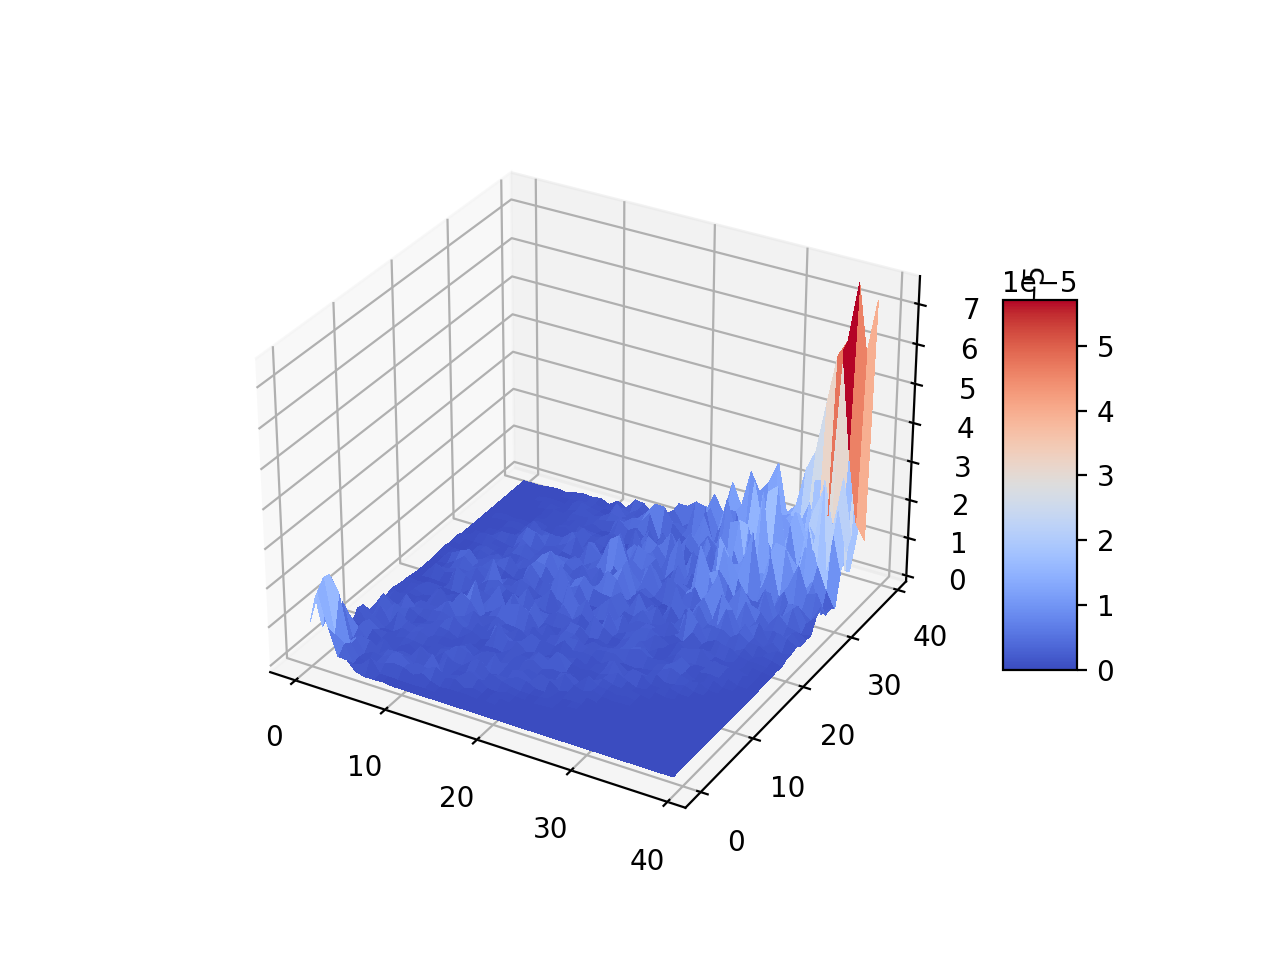

In [123]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByMIArrayDiff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

<IPython.core.display.Javascript object>


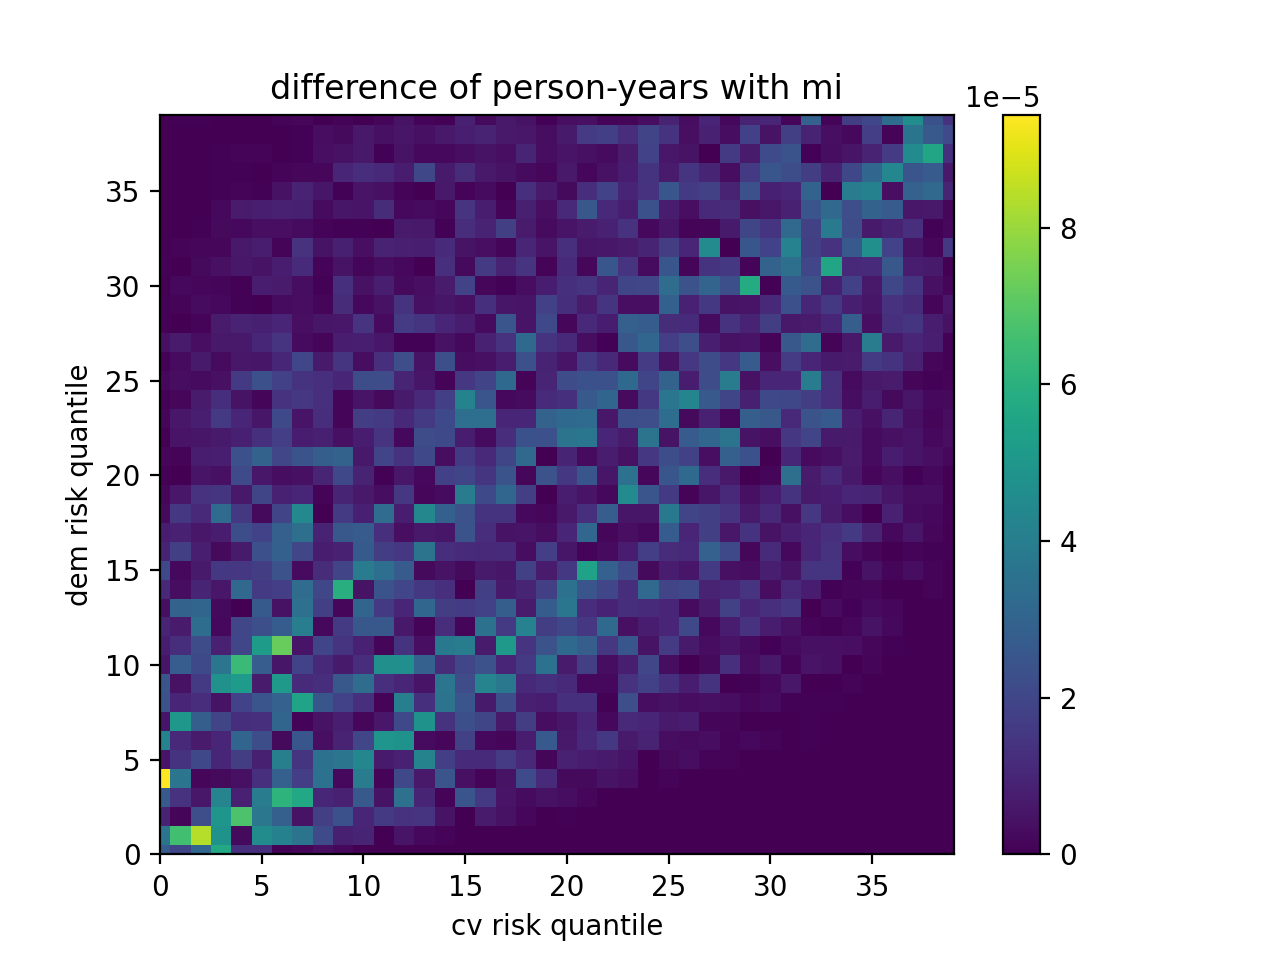

In [124]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByNoEventArrayDiff, shading='nearest')
ax.set_title('difference of person-years with mi')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

<IPython.core.display.Javascript object>


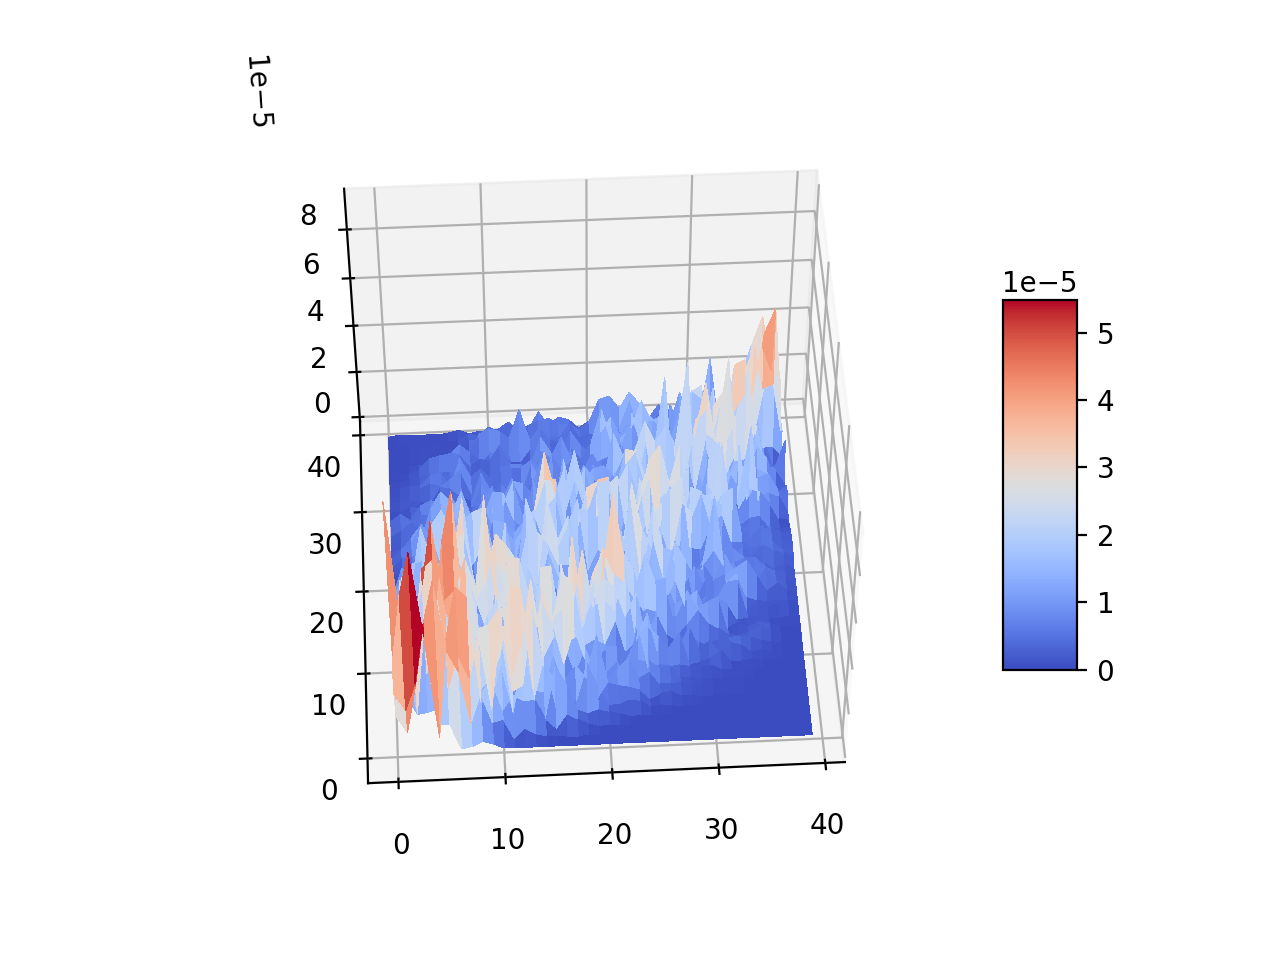

In [125]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.plot_surface(X, Y, countByNoEventArrayDiff, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [74]:
demCountSum = countByDementiaDFUsual["demCount"].sum() #sum of all person-ages
demCountSumPerQbox = demCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
#demCountSum, demCountSumPerQbox

percentCutoffAbsEffectSize = 0.05 #relevant to a uniform distribution, which qq categories to keep
cutoffDementia = (demCountSumPerQbox * percentCutoffAbsEffectSize)
#cutoff

#qqcategoriesToIncludeDementia = countByDementiaDFUsual.loc[countByDementiaDFUsual["demCount"] > cutoffDementia] 
#qqcategoriesToInclude, 
#qqcategoriesToIncludeDementia["demCount"].sum()/demCountSum #percent of person-ages included

# decide on which quantiles to keep
#includedDementia = np.zeros(X.shape)

#for i, j in zip(qqcategoriesToIncludeDementia["demRisk"],qqcategoriesToIncludeDementia["cvRisk"]):
#    includedDementia[i,j]=1
    
includedDementia = (countByDementiaArrayDiff>cutoffDementia).astype(int)

In [75]:
#(countByDementiaArrayDiff>cutoffDementia).astype(int)

<IPython.core.display.Javascript object>


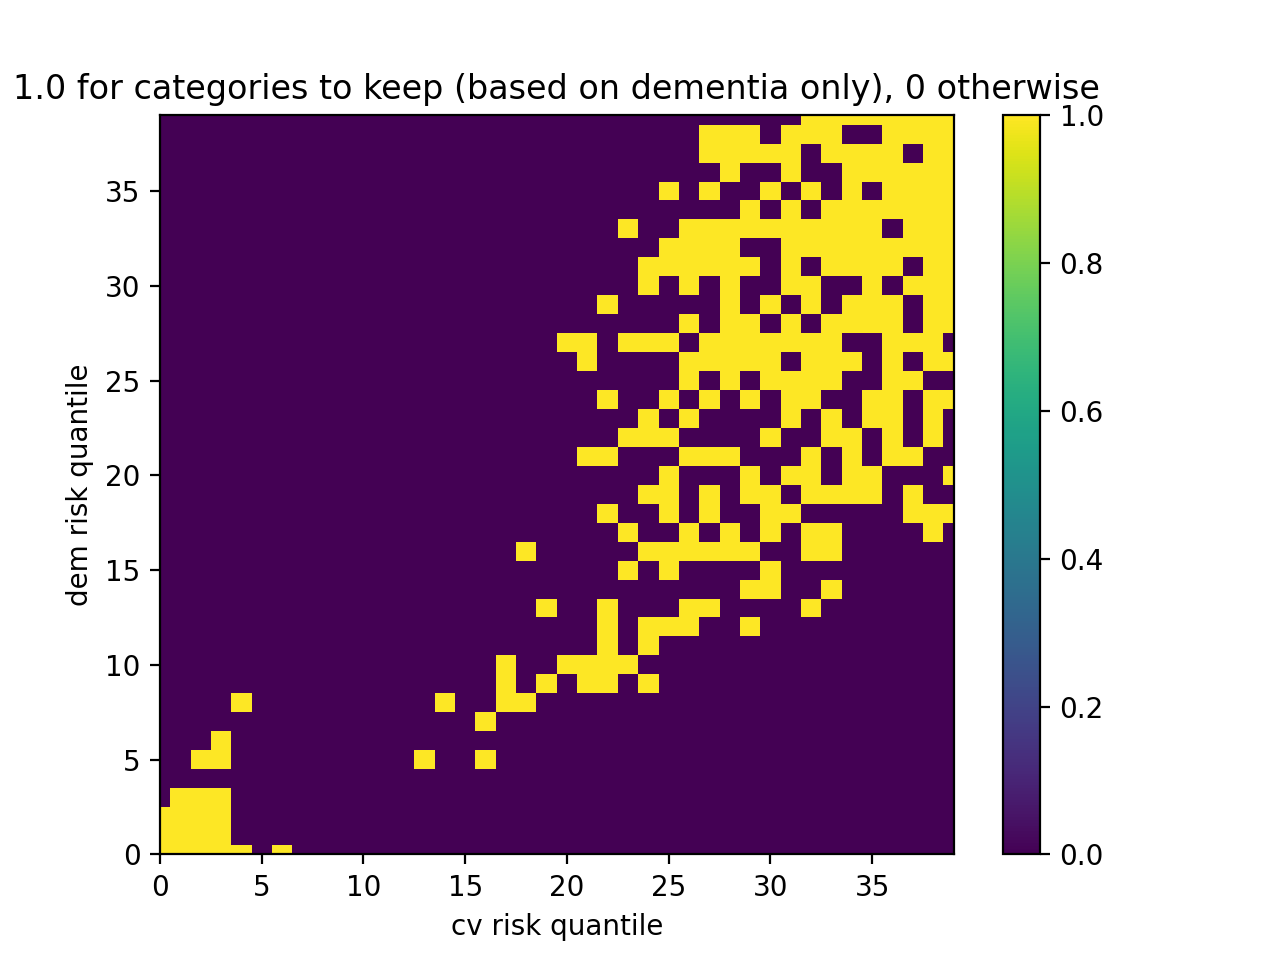

In [82]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedDementia, shading='nearest')
ax.set_title('1.0 for categories to keep (based on dementia only), 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

a different approach now, this one counts events based on people (not person-years)

In [ ]:
#import pickle
#with open(dataDir + "/demQuantileNumberForQuantile.pickle","rb") as file:
#    demQuantileNumberForQuantile=pickle.load(file)
#with open(dataDir + "/cvQuantileNumberForQuantile.pickle","rb") as file:
#    cvQuantileNumberForQuantile=pickle.load(file)

In [ ]:
nQuantiles=quantiles.shape[0]-1
#used in plots later
X=np.arange(0,nQuantiles,1)
Y=np.arange(0,nQuantiles,1)
X, Y = np.meshgrid(X, Y)
X.shape

In [ ]:
cvResultsUsual = popUsual._people.apply(OutcomeAssessor([OutcomeType.MI,OutcomeType.STROKE]).get_outcome)
cvResultsSprint = popSprint._people.apply(OutcomeAssessor([OutcomeType.MI,OutcomeType.STROKE]).get_outcome)

demResultsUsual = popUsual._people.apply(OutcomeAssessor([OutcomeType.DEMENTIA]).get_outcome)
demResultsSprint = popSprint._people.apply(OutcomeAssessor([OutcomeType.DEMENTIA]).get_outcome)

In [ ]:
cvRisksUsual = popUsual._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.CARDIOVASCULAR, 1, False))

demRisksUsual = popUsual._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.DEMENTIA, 1, False))

cvRisksSprint = popSprint._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.CARDIOVASCULAR, 1, False))

demRisksSprint = popSprint._people.apply(
                    OutcomeModelRepository().get_risk_for_person, 
                    args=(OutcomeModelType.DEMENTIA, 1, False))

In [ ]:
resultsUsual = pd.concat([cvRisksUsual,
                          demRisksUsual,
                          cvResultsUsual.astype(int),
                          demResultsUsual.astype(int)],
                         axis=1)

resultsUsual = resultsUsual.rename(columns={0:"cvRisk", 
                                            1:"demRisk",
                                            2:"cv", 
                                            3:"dementia"})
resultsSprint = pd.concat([cvRisksSprint,
                           demRisksSprint,
                           cvResultsSprint.astype(int),
                           demResultsSprint.astype(int)],
                          axis=1)
resultsSprint = resultsSprint.rename(columns={0:"cvRisk", 
                                              1:"demRisk",
                                              2:"cv", 
                                              3:"dementia"})

In [ ]:
resultsUsual.loc[resultsUsual["demRisk"]>1,"demRisk"]=1

In [ ]:
resultsUsual['demRiskQuantile'] = pd.cut(resultsUsual["demRisk"],quantiles["dementia"])
resultsUsual['cvRiskQuantile'] = pd.cut(resultsUsual["cvRisk"],quantiles["cv"])

resultsSprint['demRiskQuantile'] = pd.cut(resultsSprint["demRisk"],quantiles["dementia"])
resultsSprint['cvRiskQuantile'] = pd.cut(resultsSprint["cvRisk"],quantiles["cv"])

In [ ]:
demQuantileNumberForQuantileUsual = {quantile : index for index, quantile in 
                                enumerate(resultsUsual['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantileUsual = {quantile : index for index, quantile in 
                               enumerate(resultsUsual['cvRiskQuantile'].value_counts(sort=False).index)}

demQuantileNumberForQuantileSprint = {quantile : index for index, quantile in 
                                enumerate(resultsSprint['demRiskQuantile'].value_counts(sort=False).index)}
cvQuantileNumberForQuantileSprint = {quantile : index for index, quantile in 
                               enumerate(resultsSprint['cvRiskQuantile'].value_counts(sort=False).index)}

In [ ]:
resultsUsual['cvQuantileNum'] = resultsUsual['cvRiskQuantile']
resultsUsual['cvQuantileNum'].replace(cvQuantileNumberForQuantileUsual, inplace=True)

resultsUsual['demQuantileNum'] = resultsUsual['demRiskQuantile']
resultsUsual['demQuantileNum'].replace(demQuantileNumberForQuantileUsual, inplace=True)

resultsSprint['cvQuantileNum'] = resultsSprint['cvRiskQuantile']
resultsSprint['cvQuantileNum'].replace(cvQuantileNumberForQuantileSprint, inplace=True)

resultsSprint['demQuantileNum'] = resultsSprint['demRiskQuantile']
resultsSprint['demQuantileNum'].replace(demQuantileNumberForQuantileSprint, inplace=True)

In [ ]:
countByDementiaUsual = resultsUsual.loc[resultsUsual["dementia"]==1].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFUsual = pd.DataFrame({'demRisk' : countByDementiaUsual.index.get_level_values(0),
                              'cvRisk' : countByDementiaUsual.index.get_level_values(1),
                              'demCount' : countByDementiaUsual.values})

countByDementiaSprint = resultsSprint.loc[resultsSprint["dementia"]==1].groupby(
                                ['cvQuantileNum', 'demQuantileNum'],sort=True
                                )["dementia"].count().unstack(fill_value=0).stack()

countByDementiaDFSprint = pd.DataFrame({'demRisk' : countByDementiaSprint.index.get_level_values(0),
                              'cvRisk' : countByDementiaSprint.index.get_level_values(1),
                              'demCount' : countByDementiaSprint.values})

In [ ]:
#this is done just in case the quantile categories are not ordered properly
countByDementiaArrayUsual=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFUsual["demRisk"].values,
                 countByDementiaDFUsual["cvRisk"].values,
                 countByDementiaDFUsual["demCount"].values):
    countByDementiaArrayUsual[i,j]=k

countByDementiaArraySprint=np.zeros(X.shape)
for i,j,k in zip(countByDementiaDFSprint["demRisk"].values,
                 countByDementiaDFSprint["cvRisk"].values,
                 countByDementiaDFSprint["demCount"].values):
    countByDementiaArraySprint[i,j]=k

In [ ]:
countByDementiaArrayDiff = countByDementiaArrayUsual-countByDementiaArraySprint

In [ ]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, countByDementiaArrayDiff, shading='nearest')
ax.set_title('difference of persons with dementia')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
demCountSum = countByDementiaDFUsual["demCount"].sum() #sum of all person-ages
demCountSumPerQbox = demCountSum/(nQuantiles)/(nQuantiles) # of person-ages in one qq category, uniform ditribution
#demCountSum, demCountSumPerQbox

percentCutoffAbsEffectSize = 0.1 #relevant to a uniform distribution, which qq categories to keep
cutoffDementia = (demCountSumPerQbox * percentCutoffAbsEffectSize)
#cutoff

#qqcategoriesToIncludeDementia = countByDementiaDFUsual.loc[countByDementiaDFUsual["demCount"] > cutoffDementia] 
#qqcategoriesToInclude, 
#qqcategoriesToIncludeDementia["demCount"].sum()/demCountSum #percent of person-ages included

# decide on which quantiles to keep
#includedDementia = np.zeros(X.shape)

#for i, j in zip(qqcategoriesToIncludeDementia["demRisk"],qqcategoriesToIncludeDementia["cvRisk"]):
#    includedDementia[i,j]=1
    
includedDementia = (countByDementiaArrayDiff>cutoffDementia).astype(int)

In [ ]:
fig, ax = plt.subplots()

c = ax.pcolormesh(X, Y, includedDementia, shading='nearest')
ax.set_title('1.0 for categories to keep, 0 otherwise')
plt.xlabel("cv risk quantile")
plt.ylabel("dem risk quantile")
# set the limits of the plot to the limits of the data
ax.axis([0,nQuantiles-1, 0,nQuantiles-1])
fig.colorbar(c, ax=ax)

plt.show()

In [ ]:
anyEvent = LogisticRegressionAnalysis(
                        OutcomeAssessor([
                            OutcomeAssessor.DEATH, 
                            OutcomeType.STROKE, 
                            OutcomeType.MI, 
                            OutcomeType.DEMENTIA, 
                            OutcomeAssessor.CI]))
cogEvent = LogisticRegressionAnalysis(
                        OutcomeAssessor([
                            OutcomeAssessor.CI,
                            OutcomeType.DEMENTIA]))
vascularEventOrDeath = LogisticRegressionAnalysis(
                            OutcomeAssessor([
                                OutcomeAssessor.DEATH, 
                                OutcomeType.STROKE, 
                                OutcomeType.MI]))
#anyEvent = LogisticRegressionAnalysis(OutcomeAssessor([OutcomeAssessor.DEATH, OutcomeType.STROKE, OutcomeType.MI, OutcomeType.DEMENTIA]))
death = LogisticRegressionAnalysis(
                            OutcomeAssessor([
                                OutcomeAssessor.DEATH]))
qalys = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_qalys", AssessmentMethod.SUM))
meanGCP = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_gcp", AssessmentMethod.MEAN))
lastGCP = LinearRegressionAnalysis(
                            AttributeOutcomeAssessor(
                                "_gcp", AssessmentMethod.LAST))

In [ ]:
#results.to_csv("~/Desktop/resultstest.csv")
#results